# Text Summarization and Topic Models
* Text Summarization and Information Extraction
* Important Concepts
* Keyphrase Extractions
    1. Collocations
    2. Weighted Tag-Based Phrase Extraction
* Topic Modeling on Research Papers
    1. The Main Objective
    2. Data Retrieval
    3. Load and View Dataset
    4. Basic Text Wrangling
* Topic Models with Gensim
    1. Text Representation with Feature Engineering
    2. Latent Semantic Indexing
    3. Implementing LSI Topic Models from Scratch
    4. Latent Dirichlet Allocation
    5. LDA Models with MALLET
    6. LDA Tuning: Finding the Optimal Number of Topics
    7. Interpreting Topic Model Results
    8. Predicting Topics for New Research Papers
* Topic Models with Scikit-Learn
    1. Text Representation with Feature Engineering
    2. Latent Semantic Indexing
    3. Latent Dirichlet Allocation
    4. Non-Negative Matrix Factorization
    5. Predicting Topics for New Research Papers
    6. Visualizing Topic Models
* Automated Document Summarization
    1. Text Wrangling
    2. Text Representation with Feature Engineering
    3. Latent Semantic Analysis
    4. TextRank

In [25]:
# if spacy doesn't run
#!pip3 install spacy
#!python -m spacy download en_core_web_sm

In [26]:
# if nltk error
#import nltk
#nltk.download('all')

In [27]:
# import gensim
#!pip3 install gensim

## Important Concepts

In [28]:
# extract top k singular values and return corresponding U, S, & V matrices
from scipy.sparse.linalg import svds

def low_rank_svd(matrix, singular_count=2):
    u,s,vt = svds(matrix, k=singular_count)
    return u,s,vt

## Keyphrase Extraction

In [29]:
## Collocations
from nltk.corpus import gutenberg
import text_normalizer as tn
import nltk
from operator import itemgetter

# load corpus
alice = gutenberg.sents(fileids='carroll-alice.txt')
alice = [' '.join(ts) for ts in alice]
norm_alice = list(filter(None,
                         tn.normalize_corpus(alice, text_lemmatization=False)))

# print and compare first line
print(alice[0], '\n', norm_alice[0])

[ Alice ' s Adventures in Wonderland by Lewis Carroll 1865 ] 
 alice adventures wonderland lewis carroll


In [30]:
def compute_ngrams(sequence, n):
    return list(
            zip(*(sequence[index:]
                  for index in range(n))))

# test function
compute_ngrams([1,2,3,4], 2) # bi-grams
compute_ngrams([1,2,3,4], 3) # tri-grams

[(1, 2, 3), (2, 3, 4)]

In [31]:
# function to flatten corpus into one big string of text
def flatten_corpus(corpus):
    return ' '.join([document.strip()
                    for document in corpus])

# get top n-grams for corpus of text
def get_top_ngrams(corpus, ngram_val=1, limit=5):
    corpus = flatten_corpus(corpus)
    tokens = nltk.word_tokenize(corpus)
    
    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(),
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq)
                     for text, freq in sorted_ngrams]
    return sorted_ngrams

In [32]:
# top 10 bigrams
get_top_ngrams(corpus=norm_alice, ngram_val=2, limit=10)

[('said alice', 123),
 ('mock turtle', 56),
 ('march hare', 31),
 ('said king', 29),
 ('thought alice', 26),
 ('white rabbit', 22),
 ('said hatter', 22),
 ('said mock', 20),
 ('said caterpillar', 18),
 ('said gryphon', 18)]

In [33]:
# top 10 trigrams
get_top_ngrams(corpus=norm_alice, ngram_val=3, limit=10)

[('said mock turtle', 20),
 ('said march hare', 10),
 ('poor little thing', 6),
 ('little golden key', 5),
 ('certainly said alice', 5),
 ('white kid gloves', 5),
 ('march hare said', 5),
 ('mock turtle said', 5),
 ('know said alice', 4),
 ('might well say', 4)]

In [34]:
# use NLTK's collocation finders
# bigrams
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures

finder = BigramCollocationFinder.from_documents([item.split() for item in norm_alice])
finder

In [35]:
bigram_measures = BigramAssocMeasures()

# raw frequencies
finder.nbest(bigram_measures.raw_freq, 10)

[('said', 'alice'),
 ('mock', 'turtle'),
 ('march', 'hare'),
 ('said', 'king'),
 ('thought', 'alice'),
 ('said', 'hatter'),
 ('white', 'rabbit'),
 ('said', 'mock'),
 ('said', 'caterpillar'),
 ('said', 'gryphon')]

In [36]:
# pointwise mutual information
finder.nbest(bigram_measures.pmi, 10)

[('abide', 'figures'),
 ('acceptance', 'elegant'),
 ('accounting', 'tastes'),
 ('accustomed', 'usurpation'),
 ('act', 'crawling'),
 ('adjourn', 'immediate'),
 ('adoption', 'energetic'),
 ('affair', 'trusts'),
 ('agony', 'terror'),
 ('alarmed', 'proposal')]

In [37]:
# trigrams
from nltk.collocations import TrigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures

finder = TrigramCollocationFinder.from_documents([item.split() for item in norm_alice])

trigram_measures = TrigramAssocMeasures()

In [38]:
# raw frequencies
finder.nbest(trigram_measures.raw_freq, 10)

[('said', 'mock', 'turtle'),
 ('said', 'march', 'hare'),
 ('poor', 'little', 'thing'),
 ('little', 'golden', 'key'),
 ('march', 'hare', 'said'),
 ('mock', 'turtle', 'said'),
 ('white', 'kid', 'gloves'),
 ('beau', 'ootiful', 'soo'),
 ('certainly', 'said', 'alice'),
 ('might', 'well', 'say')]

In [39]:
# pointwise mutual information
finder.nbest(trigram_measures.pmi, 10)

[('accustomed', 'usurpation', 'conquest'),
 ('adjourn', 'immediate', 'adoption'),
 ('adoption', 'energetic', 'remedies'),
 ('ancient', 'modern', 'seaography'),
 ('apple', 'roast', 'turkey'),
 ('arithmetic', 'ambition', 'distraction'),
 ('brother', 'latin', 'grammar'),
 ('canvas', 'bag', 'tied'),
 ('cherry', 'tart', 'custard'),
 ('circle', 'exact', 'shape')]

In [40]:
## Weighted Tag-Based Phrase Extraction
data = open('elephants.txt', 'r+').readlines()
sentences = nltk.sent_tokenize(data[0])
len(sentences)

29

In [41]:
# viewing the first three lines
sentences[:3]

['Elephants are large mammals of the family Elephantidae and the order Proboscidea.',
 'Three species are currently recognised: the African bush elephant (Loxodonta africana), the African forest elephant (L. cyclotis), and the Asian elephant (Elephas maximus).',
 'Elephants are scattered throughout sub-Saharan Africa, South Asia, and Southeast Asia.']

In [42]:
norm_sentences = tn.normalize_corpus(sentences, text_lower_case=False, text_stemming=False,
                                     text_lemmatization=False, stopword_removal=False)
norm_sentences[:3]

['Elephants are large mammals of the family Elephantidae and the order Proboscidea',
 'Three species are currently recognised the African bush elephant Loxodonta africana the African forest elephant L cyclotis and the Asian elephant Elephas maximus',
 'Elephants are scattered throughout subSaharan Africa South Asia and Southeast Asia']

In [43]:
import itertools
stopwords = nltk.corpus.stopwords.words('english')

def get_chunks(sentences, grammar=r'NP: {<DT>? <JJ>* <NN.*>+}', stopword_list=stopwords):
    all_chunks = []
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    
    for sentence in sentences:
        tagged_sents = [nltk.pos_tag(nltk.word_tokenize(sentence))]
        chunks = [chunker.parse(tagged_sent)
                     for tagged_sent in tagged_sents]
        wtc_sents = [nltk.chunk.tree2conlltags(chunk)
                        for chunk in chunks]
        flattened_chunks = list(itertools.chain.from_iterable(wtc_sent for wtc_sent in wtc_sents))
        valid_chunks_tagged = [(status, [wtc for wtc in chunk])
                                    for status, chunk in itertools.groupby(flattened_chunks,
                                                      lambda word_pos_chunk: 
                                                      word_pos_chunk[2] != 'O')]
        valid_chunks = [' '.join(word.lower()
                                 for word, tag, chunk in wtc_group
                                     if word.lower() not in stopword_list)
                                        for status, wtc_group in valid_chunks_tagged if status]
        all_chunks.append(valid_chunks)
    return all_chunks

In [44]:
chunks = get_chunks(norm_sentences)
chunks

[['elephants', 'large mammals', 'family elephantidae', 'order proboscidea'],
 ['species',
  'african bush elephant loxodonta',
  'african forest elephant l cyclotis',
  'asian elephant elephas maximus'],
 ['elephants', 'subsaharan africa south asia', 'southeast asia'],
 ['elephantidae',
  'family',
  'order proboscidea',
  'extinct members',
  'order',
  'deinotheres gomphotheres mammoths',
  'mastodons'],
 ['elephants',
  'several distinctive features',
  'long trunk',
  'proboscis',
  'many purposes',
  'water',
  'grasping objects'],
 ['incisors', 'tusks', 'weapons', 'tools', 'objects'],
 ['elephants', 'flaps', 'body temperature'],
 ['pillarlike legs', 'great weight'],
 ['african elephants',
  'ears',
  'backs',
  'asian elephants',
  'ears',
  'convex',
  'level backs'],
 ['elephants', 'different habitats', 'savannahs forests deserts', 'marshes'],
 ['water'],
 ['keystone species', 'impact', 'environments'],
 ['animals',
  'distance',
  'elephants',
  'predators',
  'lions tigers hy

In [45]:
from gensim import corpora, models

def get_tfidf_weighted_keyphrases(sentences, grammar=r'NP: {<DT>? <JJ>* <NN.*>+}', top_n=10):
    valid_chunks = get_chunks(sentences, grammar=grammar)
    
    dictionary = corpora.Dictionary(valid_chunks)
    corpus = [dictionary.doc2bow(chunk) for chunk in valid_chunks]
    
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    weighted_phrases = {dictionary.get(idx): value for doc in corpus_tfidf for idx, value in doc}
    weighted_phrases = sorted(weighted_phrases.items(),
                              key=itemgetter(1), reverse=True)
    weighted_phrases = [(term, round(wt,3)) for term, wt in weighted_phrases]
    
    return weighted_phrases[:top_n]

In [46]:
# top 30 tf-idf weighted keyphrases
get_tfidf_weighted_keyphrases(sentences=norm_sentences, top_n=30)

[('water', 1.0),
 ('asia', 0.807),
 ('wild', 0.764),
 ('great weight', 0.707),
 ('pillarlike legs', 0.707),
 ('southeast asia', 0.693),
 ('subsaharan africa south asia', 0.693),
 ('body temperature', 0.693),
 ('flaps', 0.693),
 ('fissionfusion society', 0.693),
 ('multiple family groups', 0.693),
 ('art folklore religion literature', 0.693),
 ('popular culture', 0.693),
 ('ears', 0.681),
 ('males', 0.653),
 ('males bulls', 0.653),
 ('family elephantidae', 0.607),
 ('large mammals', 0.607),
 ('years', 0.607),
 ('environments', 0.577),
 ('impact', 0.577),
 ('keystone species', 0.577),
 ('cetaceans', 0.577),
 ('elephant intelligence', 0.577),
 ('primates', 0.577),
 ('dead individuals', 0.577),
 ('kind', 0.577),
 ('selfawareness', 0.577),
 ('different habitats', 0.57),
 ('marshes', 0.57)]

In [47]:
from gensim.summarization import keywords

key_words = keywords(data[0], ratio=1.0, scores=True, lemmatize=True)
[(item, round(score,3)) for item, score in key_words][:25]

[('african bush elephant', 0.261),
 ('including', 0.141),
 ('family', 0.137),
 ('cow', 0.124),
 ('forests', 0.108),
 ('female', 0.103),
 ('asia', 0.102),
 ('objects', 0.098),
 ('sight', 0.098),
 ('ivory', 0.098),
 ('tigers', 0.098),
 ('males', 0.088),
 ('folklore', 0.087),
 ('religion', 0.087),
 ('known', 0.087),
 ('larger ears', 0.085),
 ('water', 0.075),
 ('highly recognisable', 0.075),
 ('breathing lifting', 0.074),
 ('flaps', 0.073),
 ('africa', 0.072),
 ('gomphotheres', 0.072),
 ('animals tend', 0.071),
 ('success', 0.071),
 ('south', 0.07)]

## Topic Modeling on Research Papers

In [48]:
## Data Retrieval
#!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

In [49]:
# extract dataset
#!tar -xzf nips12raw_str602.tgz

In [50]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips11', 'nips10', 'nips03', 'README_yann', 'MATLAB_NOTES', 'nips08', 'nips00', 'nips06', 'nips05', 'nips12', 'nips02', 'nips04', 'idx', 'orig', 'nips07', 'nips09', 'nips01', 'RAW_DATA_NOTES']


In [51]:
## Load and View Dataset
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# read all texts into a list
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [52]:
print(papers[0][:1000])

814 
NEU1OMO1PHIC NETWORKS BASED 
ON SPARSE OPTICAL ORTHOGONAL CODES 
Mario P. Vecchi and Jawad A. Salehl 
Bell Communications Research 
435 South Street 
Morristown, NJ 07960-1961 
Abstract 
A family of neuromorphic networks specifically designed for communications 
and optical signal processing applications is presented. The information is encoded 
utilizing sparse Optical Orthogonal Code sequences on the basis of unipolar, binary 
(0, 1) signals. The generalized synaptic connectivity matrix is also unipolar, and 
clipped to binary (0, 1) values. In addition to high-capacity associative memory, 
the resulting neural networks can be used to implement general functions, such as 
code filtering, code mapping, code joining, code shifting and code projecting. 
1 Introduction 
Synthetic neural nets [1,2] represent an active and growing research field. Fundamental 
issues, as well as practical implementations with electronic and optical devices are being 
studied. In addition, several lea

In [53]:
%%time
## Basic Text Wrangling
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
        
    return norm_papers

norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 40 s, sys: 0 ns, total: 40 s
Wall time: 40.1 s


In [54]:
# viewing a processed paper
print(norm_papers[0][:50])

['neu1', 'omo1', 'phic', 'network', 'based', 'sparse', 'optical', 'orthogonal', 'code', 'mario', 'vecchi', 'jawad', 'salehl', 'bell', 'communication', 'research', 'south', 'street', 'morristown', 'nj', 'abstract', 'family', 'neuromorphic', 'network', 'specifically', 'designed', 'communication', 'optical', 'signal', 'processing', 'application', 'presented', 'information', 'encoded', 'utilizing', 'sparse', 'optical', 'orthogonal', 'code', 'sequence', 'basis', 'unipolar', 'binary', 'signal', 'generalized', 'synaptic', 'connectivity', 'matrix', 'also', 'unipolar']


## Topic Models with Gensim

In [55]:
## Text Representation with Feature Engineering
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, 
                               threshold=20, delimiter=b'_') # higher threshold fewer phrases
bigram_model = gensim.models.phrases.Phraser(bigram)

# sample demonstration
print(bigram_model[norm_papers[0]][:50])

['neu1', 'omo1', 'phic', 'network', 'based', 'sparse', 'optical', 'orthogonal', 'code', 'mario', 'vecchi', 'jawad', 'salehl', 'bell', 'communication', 'research', 'south', 'street', 'morristown', 'nj_abstract', 'family', 'neuromorphic', 'network', 'specifically', 'designed', 'communication', 'optical', 'signal_processing', 'application', 'presented', 'information', 'encoded', 'utilizing', 'sparse', 'optical', 'orthogonal', 'code', 'sequence', 'basis', 'unipolar', 'binary', 'signal', 'generalized', 'synaptic', 'connectivity', 'matrix', 'also', 'unipolar', 'clipped', 'binary']


In [56]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size', len(dictionary))

Sample word to number mappings: [(0, '2f'), (1, '2our'), (2, '3the'), (3, '82o'), (4, '86ch'), (5, '_b'), (6, '_t'), (7, '_u'), (8, '_v'), (9, '_ym'), (10, '_z'), (11, 'ability'), (12, 'absence'), (13, 'ac'), (14, 'acad_sci')]
Total Vocabulary Size 78892


In [57]:
# filer out words that occur less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


In [58]:
# transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(2, 1), (8, 1), (13, 2), (20, 1), (24, 1), (34, 2), (46, 2), (52, 1), (56, 1), (57, 2), (58, 2), (66, 1), (76, 3), (77, 1), (83, 1), (86, 1), (87, 1), (100, 1), (101, 1), (103, 1), (105, 2), (108, 1), (113, 1), (117, 1), (118, 2), (119, 1), (126, 1), (130, 1), (132, 1), (138, 2), (148, 2), (155, 1), (169, 2), (172, 1), (173, 3), (177, 2), (185, 2), (186, 2), (189, 2), (190, 1), (200, 1), (210, 3), (211, 1), (217, 1), (218, 3), (222, 4), (227, 5), (231, 2), (240, 2), (245, 1)]


In [59]:
# viewing actual terms and their counts
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('absence', 1), ('accurately', 1), ('addition', 2), ('american_institute', 1), ('application', 1), ('available', 2), ('body', 2), ('channel', 1), ('class', 1), ('clear', 2), ('clearly', 2), ('combination', 1), ('computational', 3), ('computer', 1), ('condition', 1), ('connected', 1), ('connectivity', 1), ('corresponding', 1), ('corresponds', 1), ('cross', 1), ('cycle', 2), ('defined', 1), ('design', 1), ('determined', 1), ('developed', 2), ('development', 1), ('directly', 1), ('discussion', 1), ('distinct', 1), ('easily', 2), ('end', 2), ('established', 1), ('far', 2), ('feedback', 1), ('fiber', 3), ('filter', 2), ('functional', 2), ('fundamental', 2), ('generally', 2), ('generate', 1), ('hard', 1), ('iii', 3), ('ij', 1), ('importance', 1), ('important', 3), ('indicated', 4), ('intensity', 5), ('interesting', 2), ('le', 2), ('line', 1)]


In [60]:
# total papers in the corpus
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


In [61]:
%%time
## Latent Semantic Indexing
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS, 
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 2min 34s, sys: 0 ns, total: 2min 34s
Wall time: 2min 35s


In [62]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
0.487*"neuron" + 0.396*"cell" + -0.257*"state" + 0.191*"response" + -0.187*"training" + 0.170*"stimulus" + 0.117*"activity" + -0.109*"class" + 0.099*"spike" + 0.097*"pattern" + 0.096*"circuit" + 0.096*"synaptic" + -0.095*"vector" + 0.090*"signal" + 0.090*"firing" + 0.088*"visual" + -0.084*"classifier" + -0.083*"action" + -0.078*"word" + 0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"classifica

In [63]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt,3)))
        else:
            d2.append((term, round(wt,3)))
    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('neuron', 0.487), ('cell', 0.396), ('response', 0.191), ('stimulus', 0.17), ('activity', 0.117), ('spike', 0.099), ('pattern', 0.097), ('circuit', 0.096), ('synaptic', 0.096), ('signal', 0.09), ('firing', 0.09), ('visual', 0.088), ('cortical', 0.078)]
--------------------------------------------------
Direction 2: [('state', -0.257), ('training', -0.187), ('class', -0.109), ('vector', -0.095), ('classifier', -0.084), ('action', -0.083), ('w

In [64]:
# get U, S, VT matrices from topic model
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [65]:
# document topic matrix for our LSI model
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(5)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.025,-0.011,-0.001,0.011,0.026,0.015,0.030,-0.025,-0.016,0.073
1,0.021,0.028,-0.004,0.003,-0.003,-0.000,-0.008,0.009,0.008,-0.014
2,0.027,0.007,0.006,0.017,0.017,0.035,-0.008,-0.001,-0.079,0.075
3,0.016,0.017,-0.013,0.008,0.024,0.028,0.000,-0.019,0.008,-0.006
4,0.018,0.030,-0.003,0.001,0.006,-0.031,-0.005,-0.001,0.001,0.004


In [66]:
document_numbers = [13, 250, 500]
for document_number in document_numbers:
    top_topics = list(document_topics.
                      columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T8', 'T1', 'T4']
Paper Summary:
412 
CAPACITY FOR PATTERNS AND SEQUENCES IN KANERVA'S SDM 
AS COMPARED TO OTHER ASSOCIATIVE MEMORY MODELS 
James D. Keeler 
Chemistry Department, Stanford University, Stanford, CA 94305 
and RIACS, NASA-AMES 230-5 Moffett Field, CA 94035. 
e.rnail: jdk hydra.riacs. edu 
ABSTRACT 
The information capacity of Kanerva's Sparse, Distributed Memory (SDM) and Hopfield-type 
neural networks is investigated. Under the approximations used here, it is shown that the to- 
tal information stored in these s

Document #250:
Dominant Topics (top 3): ['T8', 'T1', 'T2']
Paper Summary:
68 Baird 
Associative Memory in a Simple Model of 
Oscillating Cortex 
Bill Baird 
Dept Molecular and Cell Biology, 
U.C.Berkeley, Berkeley, Ca. 94720 
ABSTRACT 
A generic model of oscillating cortex, which assumes "minimal" 
coupling justified by known anatomy, is shown to function as an 
sociative memory, using previously developed theory. The net

In [67]:
## Implementing LSI Topic Models from Scratch
td_matrix = gensim.matutils.corpus2dense(corpus=bow_corpus, num_terms=len(dictionary))
print(td_matrix.shape)
td_matrix

(7756, 1740)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [68]:
vocabulary = np.array(list(dictionary.values()))
print('Total vocabulary size:', len(vocabulary))
vocabulary

Total vocabulary size: 7756


array(['3the', 'ability', 'absence', ..., 'smola', 'mozer_jordan',
       'kearns_solla'], dtype='<U28')

In [69]:
from scipy.sparse.linalg import svds
u, s, vt = svds(td_matrix, k=TOTAL_TOPICS, maxiter=10000)
term_topic = u
singular_values = s
topic_document = vt
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [70]:
tt_weights = term_topic.transpose() * singular_values[:,None]
tt_weights.shape

(10, 7756)

In [71]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(tt_weights), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([tt_weights[row, columns]
                                 for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t,w) for t, w in zip(terms, weights)], key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))
    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('training', 92.619), ('task', 80.732), ('pattern', 70.619), ('classifier', 56.987), ('control', 50.675), ('rule', 45.926), ('action', 41.202), ('neuron', 38.195)]
--------------------------------------------------
Direction 2: [('word', -188.486), ('vector', -85.973), ('node', -54.38), ('recognition', -53.231), ('sequence', -50.35), ('circuit', -45.396), ('cell', -44.811), ('hmm', -34.085), ('character', -34.022), ('chip', -32.162), ('matrix', -32.093), ('structure', -30.993)]
--------------------------------------------------

Topic #2:
Direction 1: [('node', 173.276), ('circuit', 92.999), ('chip', 73.593), ('classifier', 58.718), ('current', 55.844), ('voltage', 53.489), ('control', 51.709), ('rule', 45.295), ('layer', 40.265), ('analog', 38.343), ('tree', 33.483)]
--------------------------------------------------
Direction 2: [('word', -78.351), ('neuron', -69.792), ('stimulus', -63.233), ('feature', -53.819), ('distribution', -53.119), ('response', -30.954

In [72]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.
                      columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T3', 'T10', 'T7']
Paper Summary:
412 
CAPACITY FOR PATTERNS AND SEQUENCES IN KANERVA'S SDM 
AS COMPARED TO OTHER ASSOCIATIVE MEMORY MODELS 
James D. Keeler 
Chemistry Department, Stanford University, Stanford, CA 94305 
and RIACS, NASA-AMES 230-5 Moffett Field, CA 94035. 
e.rnail: jdk hydra.riacs. edu 
ABSTRACT 
The information capacity of Kanerva's Sparse, Distributed Memory (SDM) and Hopfield-type 
neural networks is investigated. Under the approximations used here, it is shown that the to- 
tal information stored in these s

Document #250:
Dominant Topics (top 3): ['T3', 'T10', 'T9']
Paper Summary:
68 Baird 
Associative Memory in a Simple Model of 
Oscillating Cortex 
Bill Baird 
Dept Molecular and Cell Biology, 
U.C.Berkeley, Berkeley, Ca. 94720 
ABSTRACT 
A generic model of oscillating cortex, which assumes "minimal" 
coupling justified by known anatomy, is shown to function as an 
sociative memory, using previously developed theory. The n

In [73]:
%%time
## Latent Dirichlet Allocation
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, 
                                   chunksize=1740, alpha='auto', eta='auto', random_state=42, 
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 2min 34s, sys: 0 ns, total: 2min 34s
Wall time: 2min 34s


In [74]:
# view topics in trained topic model
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.012*"classifier" + 0.010*"class" + 0.010*"classification" + 0.009*"training" + 0.008*"feature" + 0.006*"pattern" + 0.006*"vector" + 0.005*"tree" + 0.004*"probability" + 0.004*"test" + 0.004*"expert" + 0.004*"cluster" + 0.004*"clustering" + 0.004*"training_set" + 0.004*"distance" + 0.004*"node" + 0.003*"sample" + 0.003*"table" + 0.003*"technique" + 0.003*"application"

Topic #2:
0.017*"cell" + 0.017*"unit" + 0.016*"pattern" + 0.010*"layer" + 0.007*"activity" + 0.006*"connection" + 0.005*"synaptic" + 0.004*"synapsis" + 0.004*"activation" + 0.004*"simulation" + 0.004*"rule" + 0.004*"rat" + 0.004*"kernel" + 0.004*"perturbation" + 0.004*"active" + 0.004*"training" + 0.003*"hidden_unit" + 0.003*"effect" + 0.003*"memory" + 0.003*"region"

Topic #3:
0.016*"training" + 0.015*"unit" + 0.009*"word" + 0.008*"recognition" + 0.007*"net" + 0.007*"layer" + 0.007*"task" + 0.007*"trained" + 0.007*"hidden_unit" + 0.006*"feature" + 0.006*"pattern" + 0.006*"speech" + 0.006*"architecture" + 0.00

In [75]:
# view overall mean coherence score of model
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0976687786641732


In [76]:
# output of topic models as tuples of terms and weights
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt,3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('distribution', 0.007), ('vector', 0.006), ('training', 0.006), ('approximation', 0.005), ('linear', 0.005), ('estimate', 0.005), ('probability', 0.005), ('variable', 0.004), ('class', 0.004), ('sample', 0.004), ('matrix', 0.004), ('let', 0.004), ('gaussian', 0.004), ('equation', 0.003), ('bound', 0.003), ('prior', 0.003), ('optimal', 0.003), ('noise', 0.003), ('consider', 0.003), ('prediction', 0.003)]

Topic #2:
[('stimulus', 0.012), ('response', 0.011), ('cell', 0.011), ('visual', 0.008), ('neuron', 0.008), ('motion', 0.007), ('unit', 0.007), ('activity', 0.006), ('map', 0.006), ('direction', 0.005), ('pattern', 0.005), ('cortical', 0.004), ('spatial', 0.004), ('orientation', 0.004), ('receptive_field', 0.004), ('cortex', 0.004), ('location', 0.004), ('et_al', 0.004), ('signal', 0.004), ('field', 0.004)]

Topic #3:
[('classifier', 0.012), ('class', 0.01), ('classification', 0.01), ('training', 0.009), ('feature', 0.008), ('pattern', 0.006), ('vect

In [77]:
# view topics as a list of terms without weights, understand context or theme of each topic
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['distribution', 'vector', 'training', 'approximation', 'linear', 'estimate', 'probability', 'variable', 'class', 'sample', 'matrix', 'let', 'gaussian', 'equation', 'bound', 'prior', 'optimal', 'noise', 'consider', 'prediction']

Topic #2:
['stimulus', 'response', 'cell', 'visual', 'neuron', 'motion', 'unit', 'activity', 'map', 'direction', 'pattern', 'cortical', 'spatial', 'orientation', 'receptive_field', 'cortex', 'location', 'et_al', 'signal', 'field']

Topic #3:
['classifier', 'class', 'classification', 'training', 'feature', 'pattern', 'vector', 'tree', 'probability', 'test', 'expert', 'cluster', 'clustering', 'training_set', 'distance', 'node', 'sample', 'table', 'technique', 'application']

Topic #4:
['training', 'unit', 'word', 'recognition', 'net', 'layer', 'task', 'trained', 'hidden_unit', 'feature', 'pattern', 'speech', 'architecture', 'representation', 'character', 'sequence', 'context', 'experiment', 'training_set', 'frame']

Topic #5:

In [78]:
# use perplexity and coherence scores as measures to evaluate topic model
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams, 
                                                      dictionary=dictionary, coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()
umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams, 
                                                         dictionary=dictionary, coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.48502663515630856
Avg. Coherence Score (UMass): -1.0976687786641732
Model Perplexity: -7.799324763924073


In [79]:
## LDA Models with MALLET
# download MALLET framework
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [80]:
# extract contents from archive
# !unzip -q mallet-2.0.8.zip

In [81]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus,
                                              num_topics=TOTAL_TOPICS, id2word=dictionary, 
                                              iterations=500, workers=16)

topics=[[(term, round(wt,3)) 
         for term, wt in lda_mallet.show_topic(n, topn=20)]
             for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['image', 'feature', 'object', 'local', 'region', 'pixel', 'representation', 'distance', 'view', 'map', 'face', 'vector', 'surface', 'transformation', 'shape', 'edge', 'location', 'scale', 'structure', 'position']

Topic #2:
['circuit', 'chip', 'current', 'memory', 'bit', 'analog', 'neuron', 'voltage', 'signal', 'code', 'implementation', 'design', 'neural', 'operation', 'parallel', 'channel', 'computation', 'element', 'processor', 'application']

Topic #3:
['training', 'classification', 'word', 'classifier', 'class', 'feature', 'test', 'recognition', 'trained', 'experiment', 'training_set', 'speech', 'pattern', 'table', 'test_set', 'character', 'accuracy', 'task', 'vector', 'rate']

Topic #4:
['class', 'bound', 'size', 'linear', 'theorem', 'kernel', 'approximation', 'complexity', 'probability', 'theory', 'distribution', 'training', 'loss', 'threshold', 'optimal', 'defined', 'machine', 'polynomial', 'proof', 'hypothesis']

Topic #5:
['distribution', 'probability', 'variable', 

In [82]:
# evaluate model using perplexity and coherence metrics
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams, 
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, 
                                                                corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams, 
                                                                dictionary=dictionary, 
                                                                coherence='u_mass')

avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5203420492780962
Avg. Coherence Score (UMass): -1.0040475460488156
Model Perplexity: -8.53533


In [ ]:
## LDA Tuning: Finding the Optimal Number of Topics
from tqdm import tqdm

# iterate and build several models with differing number of topics
# select one that has highest coherence score
def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, 
                                    end_topic_count=10, step=1, cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, 
                                                            corpus=corpus, num_topics=topic_nums, 
                                                            id2word=dictionary, iterations=500, 
                                                            workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, 
                                                                     corpus=corpus, texts=texts, 
                                                                     dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

#lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, 
#                                                               texts=norm_corpus_bigrams, 
#                                                               dictionary=dictionary, 
#                                                               start_topic_count=2, 
#                                                               end_topic_count=30, step=1, 
#                                                               cpus=16)

100%|██████████| 29/29 [1:45:42<00:00, 218.70s/it]


In [88]:
#import pickle
#import numpy

# save model for later use
#filename = 'lda_models.sav'
#pickle.dump(lda_models, open(filename, 'wb'))

# save coherence scores
#np.savetxt("coherence_scores.csv", coherence_scores, delimiter=",")#

In [94]:
# load model and scores
import pickle
import numpy

filename = 'lda_models.sav'
loaded_ldas = pickle.load(open(filename, 'rb'))

coherence_scores = np.genfromtxt('coherence_scores.csv', delimiter=',')

In [87]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1), 
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
26,28,0.5421
24,26,0.5405
23,25,0.5378
15,17,0.5369
17,19,0.5361
20,22,0.5357
9,11,0.5340
13,15,0.5305
11,13,0.5294
6,8,0.5293


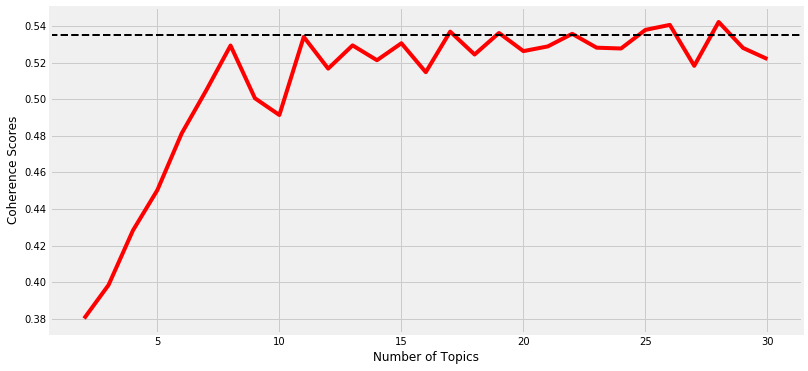

In [89]:
# plot graph showing number of topics per model and corresponding coherence scores
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2,31,1)
y_ax = coherence_scores
plt.figure(figsize=(12,6))
plt.plot(x_ax, y_ax,c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
x1 = plt.xlabel('Number of Topics')
y1 = plt.ylabel('Coherence Scores')

In [90]:
# based on graph, choose optimal number of topics as 20
# retrieve best model
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [91]:
# view all the 20 topics generated by selected best model
topics = [[(term, round(wt, 3)) 
           for term, wt in best_lda_model.show_topic(n, topn=20)] 
              for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['linear', 'nonlinear', 'vector', 'approximation', 'prediction', 'estimate', 'estimation', 'local', 'dimensional', 'regression', 'kernel', 'rbf', 'matrix', 'time_series', 'operator', 'gaussian', 'technique', 'sample', 'basis_function', 'dimension']

Topic #2:
['cell', 'response', 'stimulus', 'receptive_field', 'visual', 'cortical', 'spatial', 'cortex', 'orientation', 'activity', 'contrast', 'pattern', 'center', 'neuron', 'region', 'correlation', 'effect', 'property', 'connection', 'area']

Topic #3:
['neuron', 'cell', 'spike', 'synaptic', 'activity', 'firing', 'neural', 'synapsis', 'response', 'frequency', 'et_al', 'threshold', 'brain', 'rate', 'pattern', 'phase', 'current', 'oscillator', 'neuronal', 'fig']

Topic #4:
['word', 'recognition', 'speech', 'sequence', 'training', 'character', 'context', 'hmm', 'letter', 'frame', 'speaker', 'feature', 'state', 'speech_recognition', 'phoneme', 'trained', 'digit', 'window', 'segmentation', 'acoustic']

Topic #5:
['representation', 't

In [92]:
# build term topic dataframe
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns=['Term'+str(i) for i in range(1,21)], 
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,linear,cell,neuron,word,representation,distribution,image,state,training,motion,bound,equation,vector,constraint,node,unit,signal,circuit,training,rate
Term2,nonlinear,response,cell,recognition,task,probability,object,control,hidden_unit,direction,theorem,dynamic,memory,distance,class,layer,noise,chip,prediction,application
Term3,vector,stimulus,spike,speech,human,prior,feature,action,rule,map,class,rate,code,cluster,classification,pattern,filter,current,training_set,user
Term4,approximation,receptive_field,synaptic,sequence,target,variable,pixel,step,net,position,proof,convergence,bit,solution,classifier,activation,source,neuron,test,table
Term5,prediction,visual,activity,training,subject,gaussian,view,policy,task,field,theory,eq,pattern,transformation,training,connection,channel,analog,average,computer
Term6,estimate,cortical,firing,character,similarity,density,face,controller,trained,control,threshold,solution,capacity,structure,tree,structure,component,voltage,selection,experiment
Term7,estimation,spatial,neural,context,trial,mixture,visual,reinforcement_learning,architecture,velocity,linear,gradient,state,map,pattern,representation,frequency,neural,kernel,processor
Term8,local,cortex,synapsis,hmm,effect,bayesian,region,environment,recurrent,movement,size,matrix,matrix,clustering,feature,module,correlation,implementation,machine,run
Term9,dimensional,orientation,response,letter,study,estimate,edge,optimal,learn,location,defined,vector,binary,vector,sample,architecture,pca,gain,size,block
Term10,regression,activity,frequency,frame,theory,likelihood,shape,task,back_propagation,trajectory,complexity,state,probability,local,test,level,ica,device,ensemble,program


In [93]:
# create topic term dataframe: each topic represented in a row with terms of topic
# represented as comma-separated string
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) 
                              for topic in topics], 
                         columns=['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range (1, best_lda_model.num_topics+1)])
topics_df

,Terms per Topic
Topic1,"linear, nonlinear, vector, approximation, prediction, estimate, estimation, local, dimensional, regression, kernel, rbf, matrix, time_series, operator, gaussian, technique, sample, basis_function, dimension"
Topic2,"cell, response, stimulus, receptive_field, visual, cortical, spatial, cortex, orientation, activity, contrast, pattern, center, neuron, region, correlation, effect, property, connection, area"
Topic3,"neuron, cell, spike, synaptic, activity, firing, neural, synapsis, response, frequency, et_al, threshold, brain, rate, pattern, phase, current, oscillator, neuronal, fig"
Topic4,"word, recognition, speech, sequence, training, character, context, hmm, letter, frame, speaker, feature, state, speech_recognition, phoneme, trained, digit, window, segmentation, acoustic"
Topic5,"representation, task, human, target, subject, similarity, trial, effect, study, theory, cue, component, location, experiment, feature, condition, structure, pair, item, response"
Topic6,"distribution, probability, prior, variable, gaussian, density, mixture, bayesian, estimate, likelihood, approximation, sample, log, component, em, step, posterior, variance, probabilistic, estimation"
Topic7,"image, object, feature, pixel, view, face, visual, region, edge, shape, recognition, representation, surface, scale, contour, scene, vision, location, part, texture"
Topic8,"state, control, action, step, policy, controller, reinforcement_learning, environment, optimal, task, goal, transition, current, reward, robot, td, agent, trial, dynamic, adaptive"
Topic9,"training, hidden_unit, rule, net, task, trained, architecture, recurrent, learn, back_propagation, expert, generalization, hidden_layer, hidden, learned, backpropagation, prediction, training_set, epoch, language"
Topic10,"motion, direction, map, position, field, control, velocity, movement, location, trajectory, motor, target, visual, hand, change, arm, eye, coordinate, head, sensory"


In [ ]:
## Interpreting Topic Model Results
tm_results = best_lda_model[bow_corpus]

# get most dominant topic per research paper
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
corpus_topics[:5]

# construct master dataframe that holds base statistics
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

In [ ]:
## Dominant Topics Distribution Across Corpus
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(
    {'Dominant Topic': {'Doc Count': np.size, '% Total Docs': np.size }})

topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].
apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] 
    for t in range(len(topic_stats_df))]
topic_stats_df

In [ ]:
## Dominant Topics in Specific Research Papers
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document'].
    isin([681, 9, 392, 1622, 17, 906, 996, 503, 13, 733])])

In [ ]:
## Relevant Research Papers per Topic Based on Dominance
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set:
    (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0]))

In [ ]:
## Predicting Topics for New Research Papers
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
print('Total New Papers', len(new_papers))

In [ ]:
# build text wrangling and feature engineering pipeline
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
        for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, bigram_model=bigram_model)

norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

print(norm_new_papers[0][:30])

In [ ]:
print(norm_bow_features)

In [ ]:
# build generic fuction to extract top N topics from any research paper using trained model
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt,3)) 
                        for topic, wt in sorted(topic_predictions[i],
                        key=lamda row: -row[1])[:topn]]
                            for i in range(len(topic_predictions))]
    return best_topics

# putting the function in action
topic_preds = get_topic_predictions(topic_model=best_lda_model, corpus=norm_bow_features, topn=2)
topic_preds

In [ ]:
# review results for each paper
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in term] 
                                    for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in [[round(wt*100,2) for topic_num, wt in item] for item in topic_preds] for topic_wt in topic_list]
results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]
pd.set_option('display.max_colwidth', 300)
results_df

## Topic Models with Scikit-Learn

In [ ]:
## Text Representation with Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2), token_pattern=None, tokenizer=lambda doc: doc, preprocessor=lambda doc: doc)
cv_features = cv.fit_transform(norm_papers)
cv_features.shape

# validating vocabulary size
vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size', len(vocabulary))

In [ ]:
%%time
## Latent Semantic Indexing
from sklearn.decomposition import TruncatedSVD

TOTAL_TOPICS=20
lsi_model = TruncatedSVD(n_components=TOTAL_TOPICS, n_iter=500, random_state=42)
document_topics = lsi_model.fit_transform(cv_features)

In [ ]:
topic_terms = lsi_model.components_
topic_terms.shape

In [ ]:
# reuse previously implemented code to display topics and terms
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([topic_terms[row, columns] for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weight[n]
    term_weights = sorted([(t,w) for t, w in zip(terms, weights)],
        key = lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt,3)))
        else:
            print('Direction 1:', d1)
            print('-'*50)
            print('Direction 2:', d2)
            print('-'*50)
            print()


In [ ]:
# extract key topics for specific research papers
dt_df = pd.DataFrame(np.round(document_topics,3), 
            columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])

document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(dt_df.columns[np.argsort(-np.absolute(dt_df.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number])
    print()

In [ ]:
%%time
## Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=TOTAL_TOPICS, max_iter=500, max_doc_update_iter=50, learning_method='online', match_size=1740, learning_offset=50., random_state=42, n_jobs=16)
document_topics = lda_model.fit_transform(cv_features)

In [ ]:
# obtain topic-term matrix
# build dataframe from it to showcase topics and terms
topic_terms = lda_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics, column=['Terms per Topic'], index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

In [ ]:
# view research papers having max contribution of each of the 20 topics
dt_df = pd.DataFrame(document_topics, columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
pd.options.display.float_format = '{:, .5f}'.format
pd.set_option('display.max_colwidth', 200)

max_contrib_topics = dt_df.max(axis=0)
dominant_topics = max_contrib_topics.index
contrib_perc = max_contrib_topics.values
document_numbers = [dt_df[dt_df[t] == max_contrib_topics.loc[t]].index[0]
                        for t in dominant_topics]
documents = [papers[i] for i in document_numbers]
results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Contribution %': contrib_perc,
                            'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'],
                            'Paper Name': documents})
results_df

In [ ]:
%%time
## Non-Negative Matrix Factorization
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=TOTAL_TOPICS, solver='cd', max_iter=500, random_state=42, alpha=.1, l1_ratio=.85)
document_topics = nmf_model.fit_transform(cv_features)

In [ ]:
topic_terms = nmf_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics, columns=['Terms per Topic'],
                            index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

In [ ]:
# determine dominance of topics in research papers by absolute scores
pd.options.display.float_format = '{:, .3f}'.format
dt_df = pd.DataFrame(document_topics, columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
dt_df.head(10)

In [ ]:
# determine most relevant paper for each topic based on topic dominance scores
pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_score_topics = dt_df.max(axis=0)
dominant_topics = max_score_topics.index
term_score = max_score_topics.values
document_numbers = [dt_df[dt_df[t] == max_score_topics.loc[t]].index[0]
                        for t in dominant_topics]
documents = [papers[i] for i in document_numbers]
results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Max Score': term_score,
                            'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'],
                            'Paper Name': documents})
results_df